# Bitcoin Historical Data


Bitcoin data at 1-min intervals from select exchanges, Jan 2012 to Jan 2018

## Context

Bitcoin is the longest running and most well known cryptocurrency, first released as open source in 2009 by 
the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions
verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record 
keeping authority or central intermediary. Transaction blocks contain a SHA-256 cryptographic hash of previous
transaction blocks, and are thus "chained" together, serving as an immutable record of all transactions that 
have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments 
soon followed public adoption of bitcoin and continue to grow.

Reference Material: 

* RNN and LSTM : http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* LSTM on time series using Keras : https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/


## An unrolled recurrent neural network.


<img src='http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png'>

This chain-like nature reveals that recurrent neural networks are intimately related to sequences and lists. 
They’re the natural architecture of neural network to use for such data. In the last few years, there have been incredible success applying RNNs to a variety of problems: speech recognition, language modeling, translation, image captioning. 

## Long Short-Term Memory Network
The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using 
Backpropagation Through Time and overcomes the vanishing gradient problem.
As such, it can be used to create large recurrent networks that in turn can be used to address difficult 
sequence problems in machine learning and achieve state-of-the-art results.
Instead of neurons, LSTM networks have memory blocks that are connected through layers.
A block has components that make it smarter than a classical neuron and a memory for recent sequences. 
A block contains gates that manage the block’s state and output. A block operates upon an input sequence
and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, 
making the change of state and addition of information flowing through the block conditional.

## Content

Following are the datsets which are avaialble for use. 


* coincheckJPY_1-min_data_2014-10-31_to_2018-01-08.csv

* bitflyerJPY_1-min_data_2017-07-04_to_2018-01-08.csv

* coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv

* bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv

In [216]:
# First step, import libraries.
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import os
import plotly.graph_objs as go
import numpy as np
import plotly.offline as py
import seaborn as sns
from matplotlib import pyplot


** Dataset Imported = coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv.**

* Recoding the datetime and sorted the data by date. 
* Grouping the dataset by date and take the average price of all minutes in the day as the price of the day to minimize the fluctuation 

In [217]:
df = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv')
df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
group = df.groupby('date')
Real_Price = group['Weighted_Price'].mean()

In [218]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01


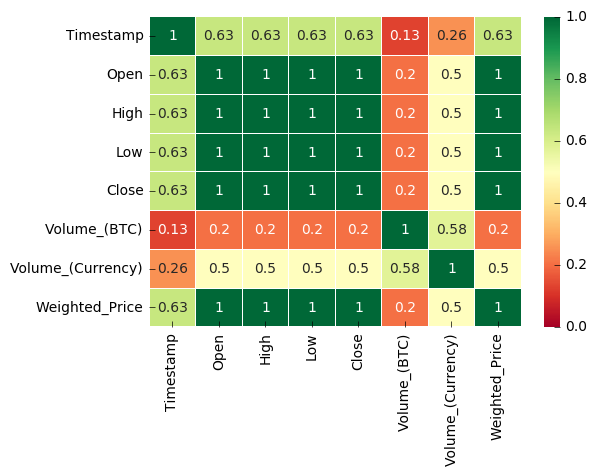

In [259]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)
plt.show()


Observation: Volume is corrlerated to Weighted Price. 
    Open, High, Low, Close are directly related to Weighted Price

In [219]:
Real_Price.head()

date
2014-12-01    366.775068
2014-12-02    375.943001
2014-12-03    377.882701
2014-12-04    377.991743
2014-12-06    378.000000
Name: Weighted_Price, dtype: float64

Extrating the data of last 30 days as the test set

In [220]:
# split data
prediction_days = 30
df_train= Real_Price[:len(Real_Price)-prediction_days]
df_test= Real_Price[len(Real_Price)-prediction_days:]

In [221]:
len(df_train)

1071

In [222]:
len(df_test)

30

In [223]:
df_train.head()

date
2014-12-01    366.775068
2014-12-02    375.943001
2014-12-03    377.882701
2014-12-04    377.991743
2014-12-06    378.000000
Name: Weighted_Price, dtype: float64

# Data Preprocessing



Feature scaling data to prepare input for Keras ( I always believe its name should be lasagna, cause it has got layers)  

For an LSTM layer, you need the shape like (NumberOfExamples, TimeSteps, FeaturesPerStep).

Passing the tuple through np.reshape where np.reshape(a, newshape, order='C')
a-array to be reshaped
newshape= length of final set
order='C'-  C-like index ordering, in this case its 1 array

The order keyword gives the index ordering both for fetching the values from a,
and then placing the values into the output array. 
For example, let’s say you have an array:
* a = np.arange(6).reshape((3, 2))
* a
* Result will be :

array([[0, 1],
       [2, 3],
       [4, 5]])

In [224]:
# Data preprocess
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
training_set

array([[  366.77506775],
       [  375.9430013 ],
       [  377.88270139],
       ...,
       [15487.71739279],
       [16144.05431135],
       [15574.30671093]])

In [225]:
type(training_set)

numpy.ndarray

As numpy has floting point value, no need of conversion. Othervise, ints are converted to floats because 
NN work better with them

## Scaling feature to a range: MinMaxScaler

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

As we have a numpy.array as an input data, we will be transforming features by scaling each feature to a 
given range. This estimator scales and translates each feature individually such that it is in the given 
range on the training set, i.e. between zero and one.

The transformation is given by:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

where min, max = feature_range.


This transformation is often used as an alternative to zero mean, unit variance scaling.

* fit_transform= It gets fits- x_min and x_max, and then transform




### Feed Forward Net Vs RNN

In feed forward nets the hidden layers weights are adjusted based on the series of input values. But in RNN, recurrent neural net, the hidden layers weights are determined by Value at Time T , and Value at Time (T-1).

Here the preicted value is T+1 so we have taken value at T to be input which is building model by getting trained on Y_Train( which is T+1)

In [226]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))


X_train=t and y_train=t+1 pattern in the numbers. 

In [227]:
y_train

array([[0.01335148],
       [0.01347285],
       [0.01347968],
       ...,
       [0.95893143],
       [1.        ],
       [0.96434953]])

In [228]:
X_train

array([[[0.01277782]],

       [[0.01335148]],

       [[0.01347285]],

       ...,

       [[0.78642872]],

       [[0.95893143]],

       [[1.        ]]])

In [229]:
len(X_train)

1070

In [230]:
len(y_train)

1070

# Implementing Keras: Building the model

Why Keras?

* First, Keras is a wrapper that allows you to use either the Theano or the TensorFlow backend! That means you can easily switch between the two, depending on your application.

* Second, it has beautiful guiding principles: modularity, minimalism, extensibility, and Python-nativeness. In practice, this makes working in Keras simple and enjoyable.

* Finally, Keras has out-of-the-box implementations of common network structures. It’s fast and easy to get a convolutional neural network up and running.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons,
and an output layer that makes a single value prediction. The default sigmoid activation function is
used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.



In [232]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Regressor is basically model we have built. Here we have assigned sequential class to it because it 
#will hold sequece of layers
regressor = Sequential()




# Adding the input layer and the LSTM layer
# expected input data shape: (batch_size, timesteps, data_dim)
#the first layer holds the number of inputs the regressor holds, that is 1 over here, given in input_shape=(None,1)
#sigmoid is default activation function used with LSTM

regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))
# returns a sequence of vectors of dimension 4

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)


Epoch 1/100
1070/1070 [==============================] - 2s 2ms/step - loss: 0.1293
Epoch 2/100
1070/1070 [==============================] - 0s 321us/step - loss: 0.0213
Epoch 3/100
1070/1070 [==============================] - 0s 327us/step - loss: 0.0149
Epoch 4/100
1070/1070 [==============================] - 0s 325us/step - loss: 0.0142
Epoch 5/100
1070/1070 [==============================] - 0s 327us/step - loss: 0.0136
Epoch 6/100
1070/1070 [==============================] - 0s 399us/step - loss: 0.0130
Epoch 7/100
1070/1070 [==============================] - 0s 414us/step - loss: 0.0123
Epoch 8/100
1070/1070 [==============================] - 0s 424us/step - loss: 0.0116
Epoch 9/100
1070/1070 [==============================] - 0s 384us/step - loss: 0.0109
Epoch 10/100
1070/1070 [==============================] - 0s 320us/step - loss: 0.0101
Epoch 11/100
1070/1070 [==============================] - 0s 378us/step - loss: 0.0094
Epoch 12/100
1070/1070 [==============================

In [233]:
history = regressor.fit(X_train, y_train, epochs=300, batch_size=100, validation_data=(X_train, y_train), verbose=0, shuffle=False)


Plot line graph to show amount loss according the the epoch


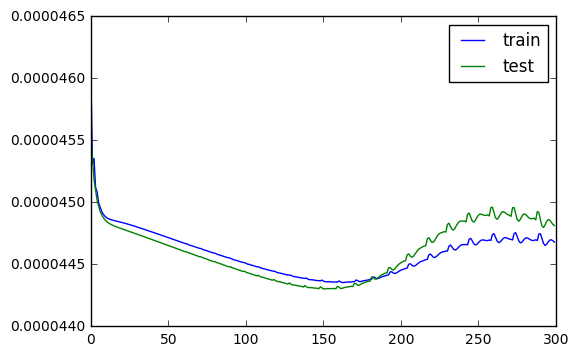

In [234]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

* **Prediction**

Notice that I only predict the price of the next day using the price today. Since there must be a lot of influence factors and it must have a lot of error when you predict a longer time.

In [235]:
len(test_set)

30

### Transforming the test doing Reshape and then normalization.

Just the way input ata is transformed, output is tansformed to predict

In [236]:
# Making the predictions
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)


In [237]:
test_set

array([14778.08775822, 16692.39851465, 17129.40795339, 17140.07518942,
       16791.15996964, 17548.21443229, 18466.78384939, 19537.27694058,
       18883.3263529 , 18400.15138622, 16865.04266576, 16345.10873036,
       13914.68688142, 15102.20616022, 14165.75384436, 14188.09605382,
       15364.19577808, 15654.23175858, 14292.86003112, 14556.45351606,
       13584.14207723, 13386.49771138, 13425.05417801, 13897.40957171,
       14989.9393498 , 14851.47788038, 15796.59696844, 16661.98824725,
       16526.9735835 , 16174.220219  ])

In [238]:
predicted_BTC_price

array([[15484.228 ],
       [16145.044 ],
       [16276.962 ],
       [16280.17  ],
       [16174.934 ],
       [16402.555 ],
       [16675.275 ],
       [16988.564 ],
       [16797.744 ],
       [16655.615 ],
       [16197.265 ],
       [16039.566 ],
       [14608.265 ],
       [15657.215 ],
       [14862.985 ],
       [14885.653 ],
       [15738.456 ],
       [15827.987 ],
       [14991.941 ],
       [15259.371 ],
       [14272.912 ],
       [14072.3955],
       [14111.512 ],
       [14590.735 ],
       [15622.291 ],
       [15544.83  ],
       [15871.779 ],
       [16135.829 ],
       [16094.874 ],
       [15987.449 ]], dtype=float32)

In [239]:
import math
from sklearn.metrics import mean_squared_error



In [240]:
X_train

array([[[0.01277782]],

       [[0.01335148]],

       [[0.01347285]],

       ...,

       [[0.78642872]],

       [[0.95893143]],

       [[1.        ]]])

# Visualising
Plot the predicted price and the real price. Compare the diference. The difference is larger when the time is further to the training set. That is why I only want to predict the price of one month

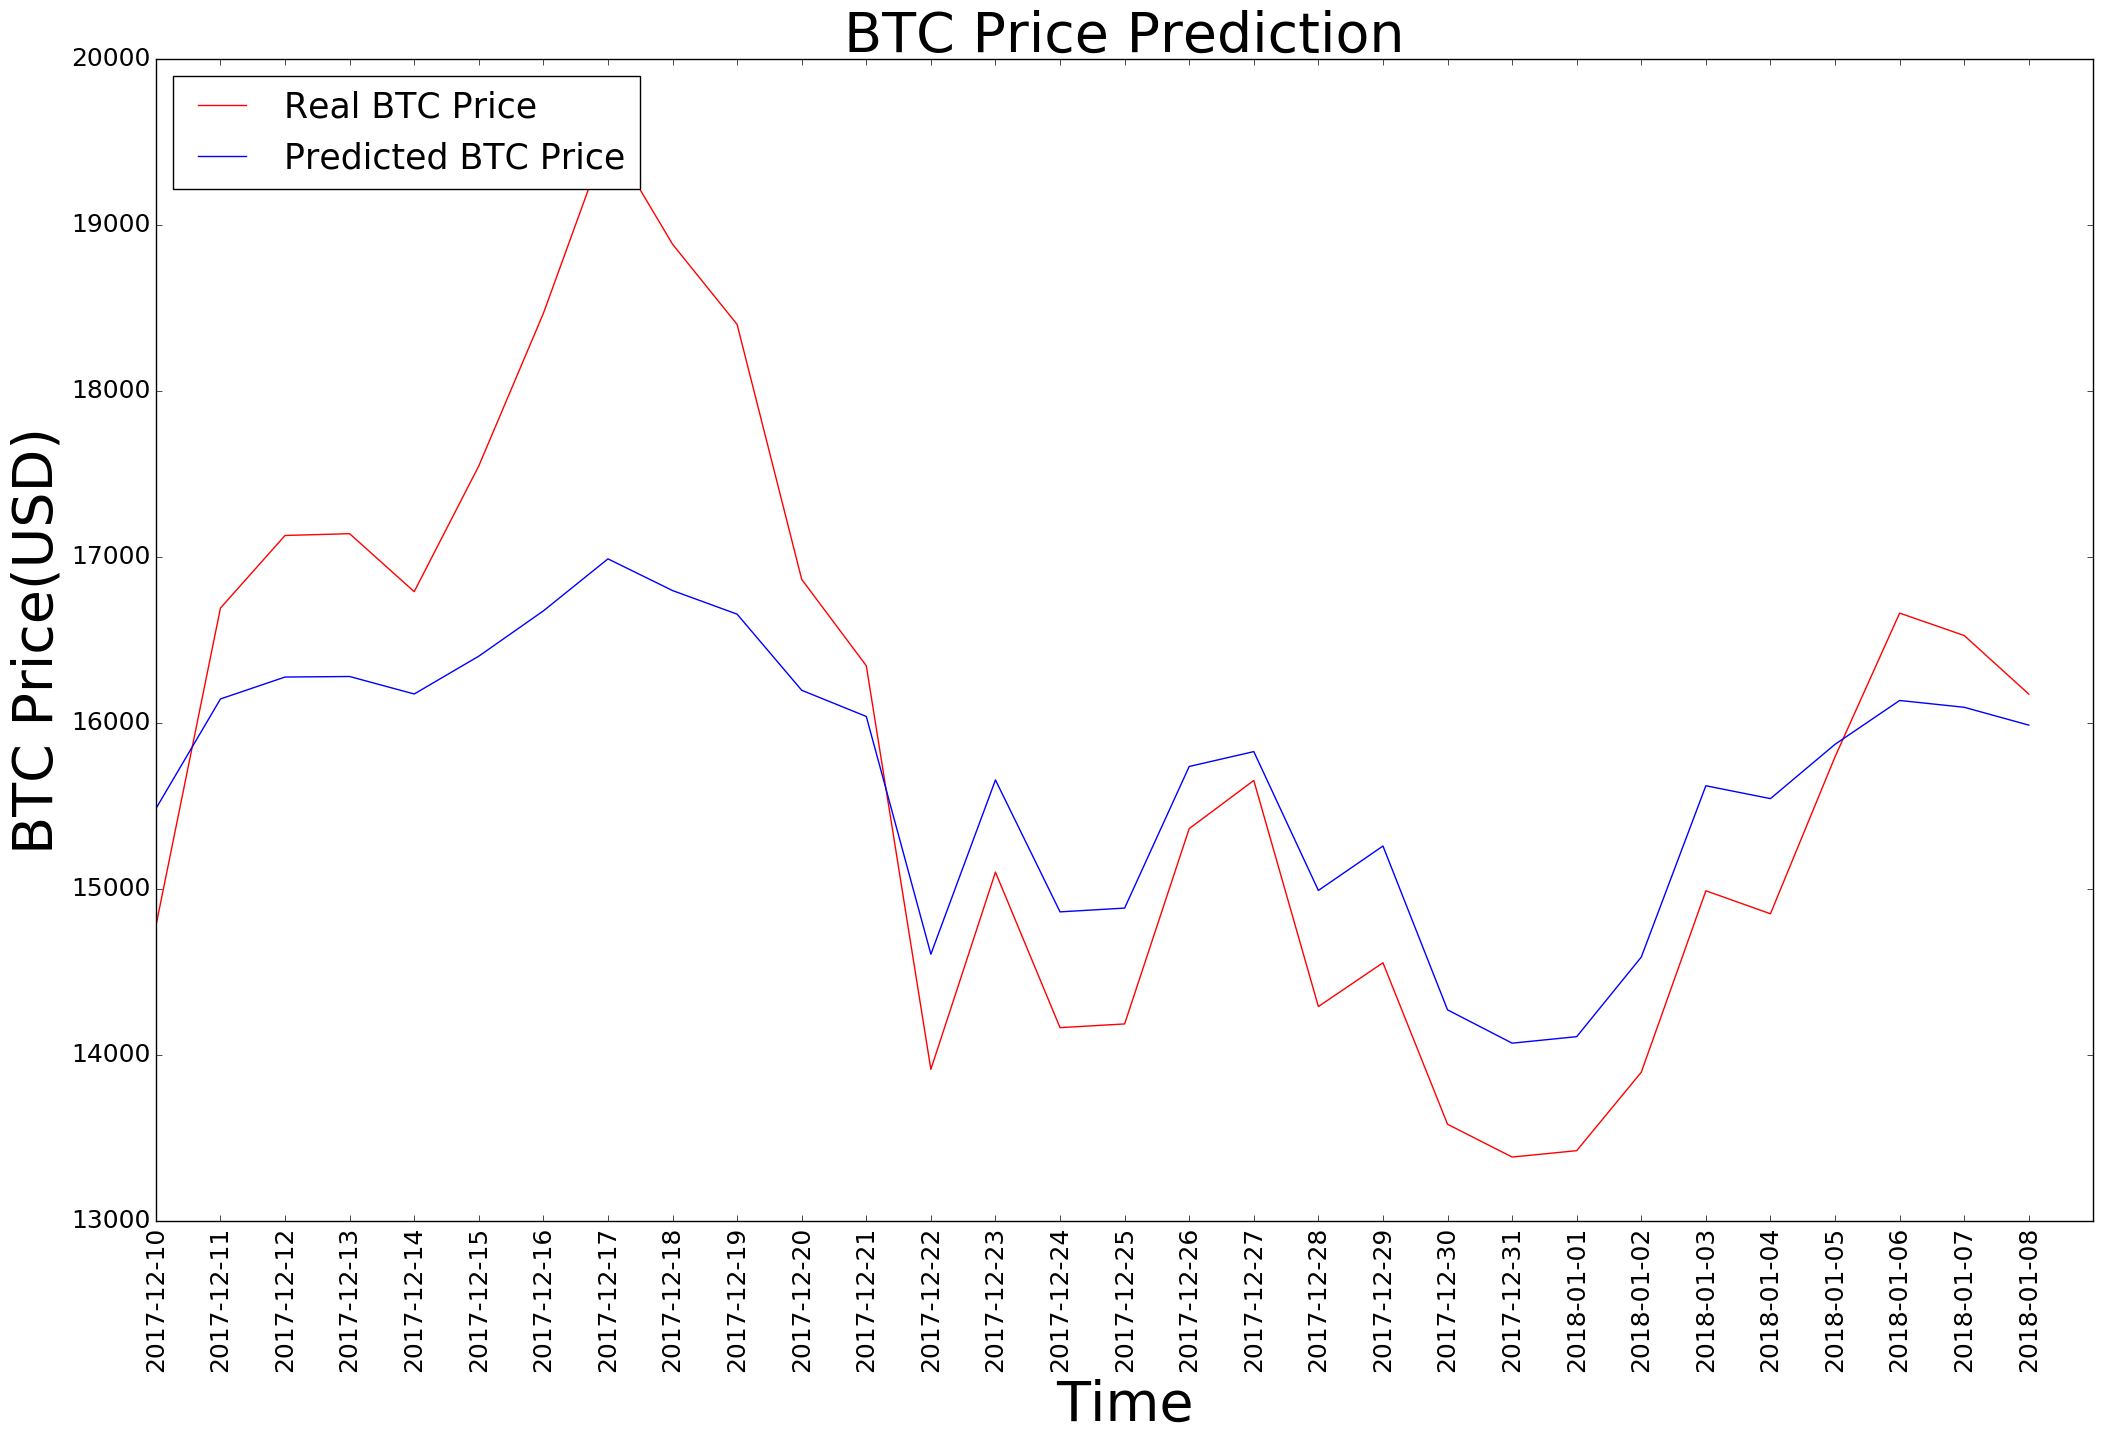

In [241]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

**Visualising**

Plot the predicted price and the real price. Compare the diference. The difference is larger when the time is further to the training set. So the prediction is done for only one month.